In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import numpy.linalg as npl
from scipy.sparse.linalg import cg

import pherosensor

from pheromone_dispersion.advection_operator import Advection, AdvectionAdjoint
from pheromone_dispersion.reaction_operator import Reaction
from pheromone_dispersion.geom import MeshRect2D
from pheromone_dispersion.velocity import Velocity

In [2]:
Lx = 20
Ly = 25
Delta_x = 0.4
Delta_y = 0.4
T_final = 5.

# Test of the numerical scheme of the adjoint of the advection operator
This notebook aims to test the implementation of the numerical scheme of the adjoint operator of the advection operator.

Recall that the advection operator is: $A:c(x,y)\mapsto \nabla\cdot(U(x,y) c(x,y))~\forall (x,y)\in\Omega$ such that $U(x,y)c(x,y)\cdot \vec{n} = 0~\forall(x,y)\in\partial\Omega_i$ with $\partial\Omega_i = \{ (x,y)\in\partial\Omega, U(x,y)\cdot\vec{n}<0\}$.\
The adjoint of the advection operator is the operator $A^*:c(x,y)\mapsto -U(x,y)\cdot\nabla c(x,y)~\forall (x,y)\in\Omega$ such that $U(x,y)c(x,y)\cdot \vec{n} = 0~\forall(x,y)\in\partial\Omega_o$ with $\partial\Omega_o = \{ (x,y)\in\partial\Omega, U(x,y)\cdot\vec{n}>0\}$.

## Reference solution

We consider the reference solution $c^{ref}(x,y) = sin\left(\frac{2\pi n_x}{L_x}x\right)sin\left(\frac{2\pi n_y}{L_y}y\right)$

In [3]:
nx = 5
ny = 7
lambda_x = 2 * np.pi * nx / Lx
lambda_y = 2 * np.pi * ny / Ly

def c_reference(x,y): 
    return np.sin(lambda_x * x) * np.sin(lambda_y * y)

and the velocity $U(x,y)=(u,v)(x,y)=(\frac{3}{L_x}x, \frac{4}{L_y}y)$.

In [4]:
def u(x):
    return 3*x/Lx

def v(y): 
    return 4*y/Ly    

def velocity_field(msh): 
    x, yi = np.meshgrid(msh.x, msh.y_horizontal_interface)
    U_hi = np.zeros((msh.y_horizontal_interface.size,msh.x.size,2))
    U_hi[:,:,0] = u(x)
    U_hi[:,:,1] = v(yi) 
    
    xi, y = np.meshgrid(msh.x_vertical_interface, msh.y)
    U_vi = np.zeros((msh.y.size,msh.x_vertical_interface.size,2))
    U_vi[:,:,0] = u(xi)
    U_vi[:,:,1] = v(y) 
    
    return Velocity(msh, U_vi, U_hi)

Therefore, we have:\
$\partial_xc^{ref}(x,y)=\frac{2\pi n_x}{L_x}cos\left(\frac{2\pi n_xx}{L_x}\right)sin\left(\frac{2\pi n_yy}{L_y}\right)$,\
$\partial_yc^{ref}(x,y)=\frac{2\pi n_y}{L_y}sin\left(\frac{2\pi n_xx}{L_x}\right)cos\left(\frac{2\pi n_yy}{L_y}\right)$.\
We can note that the reference solution satisfies the boundary conditions.

Hence, we have $A^*c^{ref}(x,y) = U(x,y)\cdot\nabla c^{ref}(x,y) = u(x,y)\frac{2\pi n_x}{L_x}cos\left(\frac{2\pi n_xx}{L_x}\right)sin\left(\frac{2\pi n_yy}{L_y}\right) + v(x,y)\frac{2\pi n_y}{L_y}sin\left(\frac{2\pi n_xx}{L_x}\right)cos\left(\frac{2\pi n_yy}{L_y}\right)$

In [5]:
def ATc_reference(x,y): 
    res = - u(x) * lambda_x * np.cos(lambda_x * x) * np.sin(lambda_y * y)
    res+= - v(y) * lambda_y * np.sin(lambda_x * x) * np.cos(lambda_y * y)
    return res

## Numerical scheme

The numerical scheme used is a finite volume scheme. The average of the advection operator over a control volume $\Omega_{i,j}$ is : 
\begin{align*}
-\frac{1}{|\Omega_{i,j}|} \int_{\Omega_{i,j}} U(x,y)\cdot\nabla c(x,y)dx dy &= -\frac{1}{|\Omega_{i,j}|} \int_{\Omega_{i,j}} \nabla\cdot(U(x,y) c(x,y))dx dy + \frac1{|\Omega_{i,j}|} \int_{\Omega_{i,j}} c(x,y)\nabla\cdot U(x,y)dx dy\\
&= \frac{1}{|\Omega_{i,j}|} \int_{\partial \Omega_{i,j}}-U(x,y)c(x,y)\cdot \vec{n} dx dy + \frac1{|\Omega_{i,j}|} \int_{\Omega_{i,j}} c(x,y)\nabla\cdot U(x,y)dx dy
\end{align*}
In the present case, we use uniform cartesian meshes with the same space step along the two axis. We will denote by the indexes $i+\frac{1}{2},j$ the vertical interface between the control volumes $i,j$ and $i+1,j$, and similarly for the horizontal interfaces. Moreover, let us note that on the vertical interfaces $\vec{n}=(\pm1,0)$ and on the horizontal interfaces $\vec{n}=(0,\pm1)$.\
Therefore, we have: $\frac1{|\Omega_{i,j}|} \int_{\partial \Omega_{i,j}}U(x,y)c(x,y)\cdot \vec{n} dx dy \approx \frac1{|\Omega_{i,j}|}\left(-\Delta y\left(c_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j}-c_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}\right)-\Delta x\left(c_{i,j+\frac{1}{2}}v_{i,j+\frac{1}{2}}-c_{i,j-\frac{1}{2}}v_{i,j-\frac{1}{2}}\right)\right)$.\
In the present case, the scheme is a downwind scheme (upwind considering the opposite velocity field). Therefore, the concentration at the interfaces are given by: 
- if $U_{i\pm1/2,j}\cdot \vec{n} = u_{i\pm1/2,j} < 0$, then $c_{i\pm1/2,j} = c_{i\pm1/2-1/2,j}$, else $c_{i\pm1/2,j} = c_{i\pm1/2+1/2,j}$,
- if $U_{i,j\pm1/2}\cdot \vec{n} = v_{i,j\pm1/2} < 0$, then $c_{i,j\pm1/2} = c_{i,j\pm1/2-1/2}$, else $c_{i,j\pm1/2} = c_{i,j\pm1/2+1/2}$.

Moreover, the divergence of $U$ is computed using a centered scheme: $\nabla\cdot U_{i,j} = \frac{u_{i+1/2,j}-u_{i-1/2,j}}{\Delta x}+\frac{v_{i,j+1/2}-v_{i,j-1/2}}{\Delta y}$.\
And we denote $A^{*solver}c(x_i,y_j) = \frac{1}{|\Omega_{i,j}|}\left(-\Delta y\left(c_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j}-c_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}\right)-\Delta x\left(c_{i,j+\frac{1}{2}}v_{i,j+\frac{1}{2}}-c_{i,j-\frac{1}{2}}v_{i,j-\frac{1}{2}}\right)\right)+\left(\frac{u_{i+1/2,j}-u_{i-1/2,j}}{\Delta x}+\frac{v_{i,j+1/2}-v_{i,j-1/2}}{\Delta y}\right)c_{i,j}$

In [6]:
space_factor_a = [0.005, 0.01, 0.1, 1.]
dx_a = np.zeros(len(space_factor_a))

MAE = np.zeros(len(space_factor_a))
RMSE = np.zeros(len(space_factor_a))

for i, space_factor in enumerate(space_factor_a):
    
    msh = MeshRect2D(Lx, Ly, Delta_x*space_factor, Delta_y*space_factor, T_final)
    x, y = np.meshgrid(msh.x, msh.y)
    dx_a[i] = Delta_x*space_factor
    
    c_ref = c_reference(x, y)
    ATc_ref = ATc_reference(x,y)

    U = velocity_field(msh)
    
    AT = AdvectionAdjoint(U, msh) 
    ATc_solver = AT.matvec(c_ref.reshape((msh.y.size * msh.x.size,)))
    ATc_solver = ATc_solver.reshape((msh.y.size, msh.x.size))
    
    RMSE[i] = npl.norm(ATc_solver - ATc_ref) / np.sqrt(ATc_ref.size)
    MAE[i] = np.mean(np.abs(ATc_solver-ATc_ref))
    
    print("")
    print("dx = ", msh.dx)


dx =  0.002

dx =  0.004

dx =  0.04000000000000001

dx =  0.4


## Analysis of the truncation error
In the present case, since the components of the velocity field are positive ($u,v\geq0$) and due to the uniform cartesian mesh (with $\Delta x = \Delta y$), the upwind finite volume scheme is equivalent to a standard downwind finite difference scheme.\
Hence, we have the truncation error $Rc(x,y) = |A^{*solver}c(x,y) - A^*c(x,y)|=\mathcal{O}(\Delta x)$.

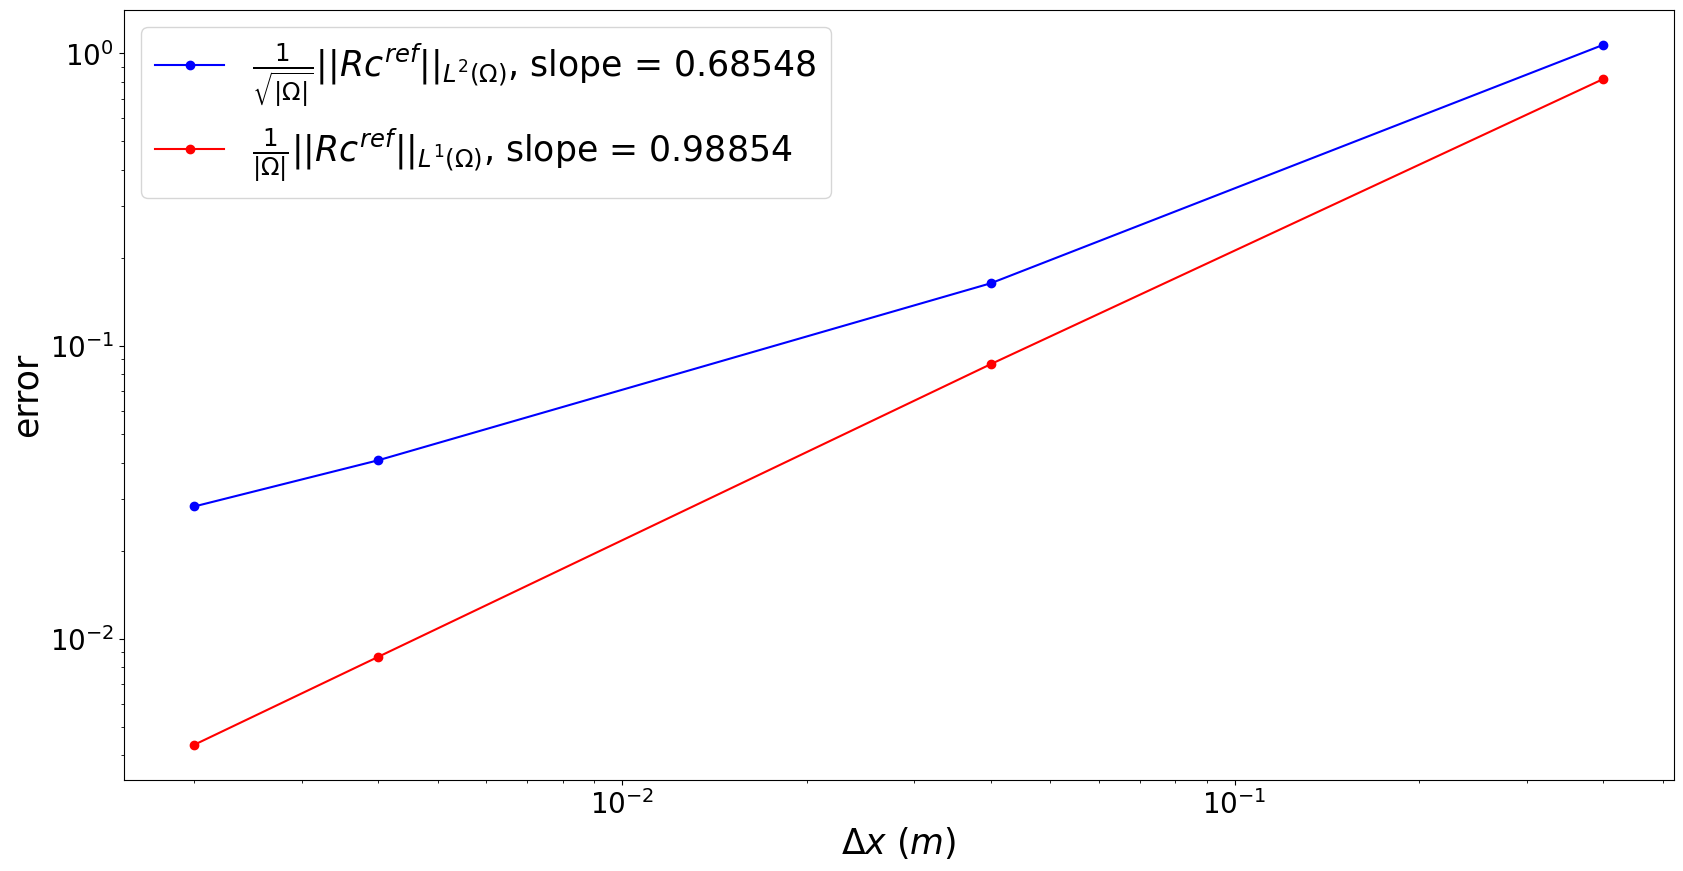

In [7]:
slope_MAE = (np.log(MAE[0]) - np.log(MAE[-1])) / (np.log(dx_a[0]) - np.log(dx_a[-1])) 
slope_RMSE = (np.log(RMSE[0]) - np.log(RMSE[-1]) ) / ( np.log(dx_a[0]) - np.log(dx_a[-1])) 

fontsize = 25
fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.plot(dx_a,RMSE,'-ob',label=r'$\frac{1}{\sqrt{|\Omega|}}||Rc^{ref}||_{L^2(\Omega)}$'+f', slope = {"{:.5f}".format(slope_RMSE)}')
ax1.plot(dx_a,MAE,'-or',label=r'$\frac{1}{|\Omega|}||Rc^{ref}||_{L^1(\Omega)}$'+f', slope = {"{:.5f}".format(slope_MAE)}')

ax1.tick_params(axis='both',labelsize=fontsize-5)
ax1.set_ylabel(r'error', fontsize=fontsize)
ax1.set_xlabel('$\Delta x$ ($m$)', fontsize=fontsize)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc='upper left',prop={'size': fontsize})


# Scalar product test for the adjoint of the advection operator


This section aims at performing the scalar product test between the advection operator and its adjoint. It also enables to check that the scheme of the adjoint of the advection operator corresponds the adjoint of the scheme of the advection operator. 

The test of the scalar product consists in checking that $<Ac_1,c_2>\approx<c_1,A^*c_2>$ for any $c_1$ and $c_2$ (here picked randomly).

In [8]:
msh = MeshRect2D(Lx, Ly, Delta_x, Delta_y, T_final)
U = velocity_field(msh)

AT = AdvectionAdjoint(U, msh) 
A = Advection(U, msh)

np.random.seed(0)
c1 = np.random.normal(0, 1, size=msh.x.size*msh.y.size)
c2 = np.random.normal(0, 1, size=msh.x.size*msh.y.size)

prod_scal_A = np.dot(c2,A.matvec(c1))
prod_scal_AT = np.dot(c1,AT.matvec(c2))

print("<Ac_1,c_2> = ",prod_scal_A)
print("<c_1,A*c_2> = ",prod_scal_AT)
print("|<Ac_1,c_2>-<c_1,A*c_2>| = ", np.abs(prod_scal_A-prod_scal_AT))

<Ac_1,c_2> =  -170.63794325367223
<c_1,A*c_2> =  -170.63794325367212
|<Ac_1,c_2>-<c_1,A*c_2>| =  1.1368683772161603e-13
